# TP images: transformations 2D et interpolation
## Données numériques - 2022-23
### Diane Lingrand (Diane.Lingrand@univ-cotedazur.fr)

In [72]:
#%matplotlib qt

In [73]:
#%matplotlib notebook
%matplotlib inline

In [74]:
#%matplotlib --list

In [75]:
#matplotlib

In [76]:
import skimage
from skimage import io
from skimage import data
from skimage import transform
import numpy as np
from matplotlib import pyplot as plt

## Image issue de la bibliothèque scikit-image

In [77]:
img = data.coffee() #io.imread('/home/lingrand/2020-11-24-couvert.jpg') #data.coffee()
# on peut sauver une image afin de la visualiser dans un autre outil
io.imsave("coffee.png",img)

In [78]:
print(img.shape)

(400, 600, 3)


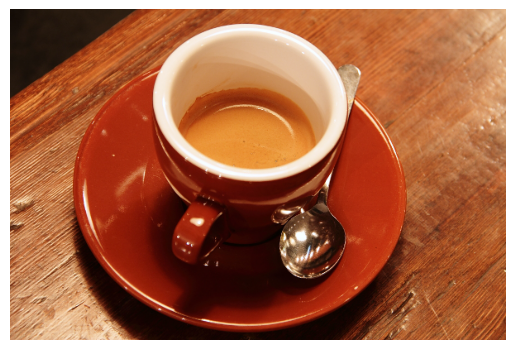

In [79]:
plt.axis('off')
plt.imshow(img)

On va s'intéresser à la visualisation de l'image dans sa taille réelle (1 pixel de l'écran = 1 pixel de l'image). La fonction 'figimage' devrait le permettre mais dans un notebook jupyter, on est dépendant du dpi lié au butineur.

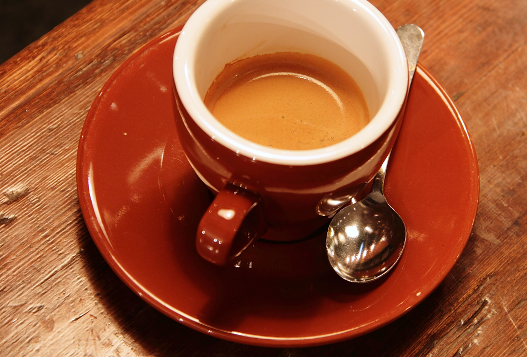

In [80]:
fig,ax = plt.subplots()
fig.figimage(img, resize=True)
plt.show()

Si vous avez utilisé "%matplotlib inline" ou si le facteur d'échelle de votre butineur est trop petit (view/zoom), il manque malheureusement une partie de l'image. 

In [81]:
import math
# calcul du dpi pour mon écran
# 1920x1080 et 27 pouces
print('diagonale en pixels ', math.sqrt(1920**2+1080**2))
dpi = math.sqrt(1920**2+1080**2)/27
print('dpi =',dpi)

diagonale en pixels  2202.9071700822983
dpi = 81.58915444749253


Un dpi de 82 devrait convenir mais c'est sans compter la transformation effectuée par le butineur. Si vous voulez éviter toute transformation, une visualisation des images dans une fenêtre extérieure est préférable (voir le début du notebook avec par exemple %matplotlib qt).

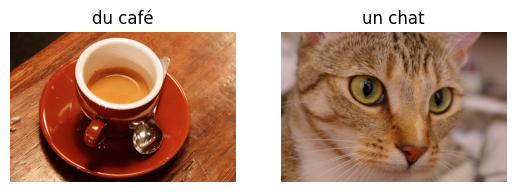

In [82]:
#une figure avec 2 images
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = axes.ravel()
ax[0].axis('off')
ax[0].imshow(data.coffee())
ax[0].title.set_text('du café')
ax[1].axis('off')
ax[1].imshow(data.chelsea())
ax[1].title.set_text('un chat')

## Rotation (votre implémentation)

In [83]:
angle = 30 # en degrés. Valeur à modifier par la suite
center = [0,0] # centre de la rotation: à modifier ...

**Question 1:** Ecrire une fonction qui prend en entrée une image, un angle, un centre et retourne l'image après rotation autour du centre de l'angle donné.

Différentes questions se posent:
- créer une nouvelle image de mêmes dimensions
- calculer la rotation (dans les slides)
- trouver la valeur d'un pixel sur des coordonnées non entières: commencer par l'interpolation au plus proche voisin
- gérer les coordonnées en dehors de l'image (0 par défaut)

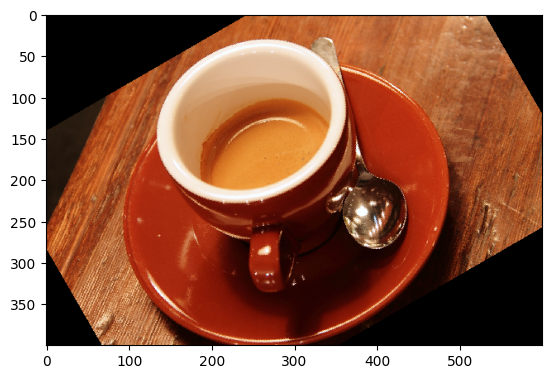

In [89]:
def rotationImage(i, a):
    # Obtenir les dimensions de l'image
    h, w = i.shape[:2]

    # Calculer le centre de l'image
    center = (w / 2, h / 2)

    a_rad = np.radians(a)

    newI = np.zeros_like(i)

    for y in range(h):
        for x in range(w):
            x_src = int(0.5 + center[0] + (x - center[0]) * math.cos(a_rad) - (y - center[1]) * math.sin(a_rad))
            y_src = int(0.5 + center[1] + (x - center[0]) * math.sin(a_rad) + (y - center[1]) * math.cos(a_rad))

            if 0 <= x_src < w and 0 <= y_src < h:
                newI[y, x] = i[y_src, x_src]

    return newI


# Plot image data.coffee() rotated by 30 degrees
im = rotationImage(data.coffee(), angle)
plt.imshow(im)


**Question 2:** Modifiez la fonction précédente afin d'ajouter l'ordre d'interpolation dans les paramètres. Utilisez une autre fonction valPixel pour gérer les ordres d'interpolation (pour le moment, seule l'interpolation au plus proche voisin doit être implémentée). Cette dernière fonction prend en entrée une image, des coordonnées de pixel en flottants, un numéro de canal et un ordre d'interpolation. Lors qu'une image n'a pas de canaux (niveaux de gris), le paramètre ch ne sera pas utilisé.

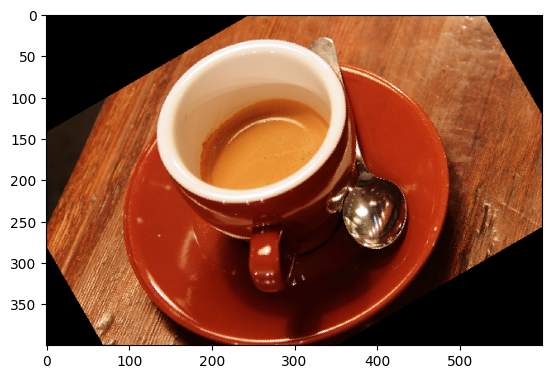

In [86]:
# ordre = 0 : interpolation au plus proche voisin
# ordre = 1 : interpolation bilinéaire

def rotationImage(im, an, ce, ordre=0):
    h, w = im.shape[:2]
    center = (w / 2, h / 2)
    a_rad = np.radians(an)
    newI = np.zeros_like(im)
    
    a_rad_cos = math.cos(a_rad)
    a_rad_sin = math.sin(a_rad)
    for y in range(h):
        for x in range(w):
            x_src = center[0] + (x - center[0]) * a_rad_cos - (y - center[1]) * a_rad_sin
            y_src = center[1] + (x - center[0]) * a_rad_sin + (y - center[1]) * a_rad_cos

            if 0 <= x_src < w - 1 and 0 <= y_src < h - 1:
                for ch in range(im.shape[2]):
                    newI[y, x, ch] = valPixel(im, x_src, y_src, ch, ordre)

    return newI

def valPixel(im, x, y, ch=0, ordre=0):
    if ordre == 0:
        return nearest_neighbor(im, x, y, ch)
    return nearest_neighbor(im, x, y, ch)  # On nous demande que l'ordre 0 mais il faudrait gérer le cas ordre=n

def nearest_neighbor(im, x, y, ch):
    return im[int(round(y)), int(round(x)), ch]

# Plot image data.coffee() rotated by 30 degrees
im = rotationImage(data.coffee(), angle, center)
plt.imshow(im)

**Question 3:** Ajoutez la possibilité de plonger l'image dans une plus grande image avec des bords noirs afin de ne pas rogner les angles lors de la rotation (astuce: utiliser numpy.pad).

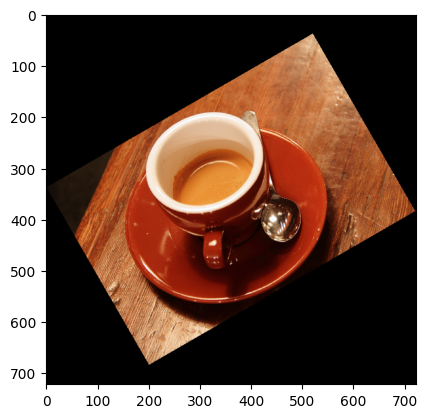

In [92]:
def rotationImage(im, an, ce, ordre=0, padding=True):
    h, w = im.shape[:2]
    center = (w / 2, h / 2)
    a_rad = np.radians(an)

    if padding:
        diagonal = int(np.ceil(np.sqrt(h ** 2 + w ** 2)))
        padx = (diagonal - w) // 2
        pady = (diagonal - h) // 2
        im = np.pad(im, ((pady, pady), (padx, padx), (0, 0)), mode='constant')
        center = (center[0] + padx, center[1] + pady)
    
    h, w = im.shape[:2]
    newI = np.zeros_like(im)

    for y in range(h):
        for x in range(w):
            x_src = center[0] + (x - center[0]) * math.cos(a_rad) - (y - center[1]) * math.sin(a_rad)
            y_src = center[1] + (x - center[0]) * math.sin(a_rad) + (y - center[1]) * math.cos(a_rad)

            if 0 <= x_src < w - 1 and 0 <= y_src < h - 1:
                for ch in range(im.shape[2]):
                    newI[y, x, ch] = valPixel(im, x_src, y_src, ch, ordre)

    return newI

# Plot image data.coffee() rotated by 30 degrees
im_tmp = rotationImage(data.coffee(), angle, center)
plt.imshow(im_tmp)

**Question 4:** Modifiez la fonction valPixel pour prendre en compte également l'interpolation bilinéaire.

0 0


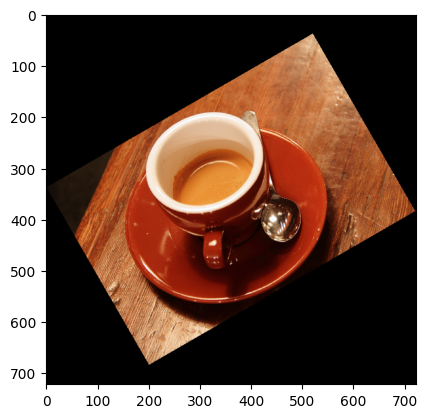

In [94]:
import numpy as np

def valPixel(im, x, y, ch=0, ordre=0):
    if ordre == 0:
        return nearest_neighbor(im, x, y, ch)
    elif ordre == 1:
        return bilinear_interpolation(im, x, y, ch)
    else:
        return nearest_neighbor(im, x, y, ch)

def bilinear_interpolation(im, x, y, ch):
    x1, y1 = int(np.floor(x)), int(np.floor(y))
    x2, y2 = x1 + 1, y1 + 1

    if x2 >= im.shape[1] or y2 >= im.shape[0]:
        return nearest_neighbor(im, x, y, ch)

    q11 = im[y1, x1, ch]
    q12 = im[y2, x1, ch]
    q21 = im[y1, x2, ch]
    q22 = im[y2, x2, ch]

    fxy1 = q11 * (x2 - x) + q21 * (x - x1)
    fxy2 = q12 * (x2 - x) + q22 * (x - x1)

    return fxy1 * (y2 - y) + fxy2 * (y - y1)

# Plot image data.coffee() rotated by 30 degrees
im = rotationImage(data.coffee(), angle, center)
plt.imshow(im)

# Test soustraction d'images
s = abs(im_tmp - im)
print(np.min(s), np.max(s))

**Question 5:** Comparez l'interpolation au plus proche voisin et l'interpolation bilinéaire. Effectuez plusieurs rotations successives

## Rotation  avec scikit-image

La rotation est décrite dans la documentation de <a href="https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate">skimage.transform.rotate</a>. Quel est le centre de rotation par défaut? Dans quelle unité les angles sont-ils définis?

**Question 6:**: Affichez une image ainsi que sa rotation d'un angle de 30 degrés (sens anti-horaire) autour du centre de l'image. Comparez l'interpolation au plus proche voisin et l'interpolation bi-linéaire.

Dans la documentation, il est précisé, pour le paramètre 'order', entier, optionnel: 

The order of interpolation. The order has to be in the range 0-5:

- 0: Nearest-neighbor
- 1: Bi-linear (default)
- 2: Bi-quadratic
- 3: Bi-cubic
- 4: Bi-quartic
- 5: Bi-quintic

Default is 0 if image.dtype is bool and 1 otherwise.



In [ ]:
# à vous 

**Question 7:** Effectuez plusieurs rotations successives et comparez les résultats pour les ordres 0, 1 et 3. S'il vous reste du temps en fin de TP, vous pouvez tester les autres ordres et mesurer également les temps de calcul.

In [ ]:
# à vous
 

## Changement d'échelle (avec scikit-image)

Que choisir pour le changement d'échelle: <a href="https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rescale">rescale</a> ou <a href="https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize">resize</a>?

Attention, pour la fonction skimage.transform.rescale, si vos images ne sont pas en niveaux de gris (e.g. couleur), il faut spécifier qu'il y a plusieurs canaux:

image2 = skimage.transform.rescale(image, 2.4, multichannel=True)

In [ ]:
# à vous de jouer

Vous pouvez également tester différentes <a href="https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.AffineTransform">transformations afffines</a>.